<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/flood_segmentation_v2_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Flooded area segmentation using attention unet**

**Imports and dataset**

In [1]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [2]:
!pip install focal_loss -q

In [3]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import glob

In [4]:
images = sorted(glob.glob('/content/drive/MyDrive/archive/Image/*.jpg'))
masks = sorted(glob.glob('/content/drive/MyDrive/archive/Mask/*.png'))
len(images), len(masks)

(290, 290)

**Custom data generator**

In [7]:
import numpy as np
import cv2
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, img_size=(512, 512), shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.images = images #os.listdir(image_folder)
        self.masks = masks #os.listdir(mask_folder)

        # on each epoch end, shuffle the dataset
        self.on_epoch_end()

        # datagen function to augment the input image and mask pair
        self.datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode = 'constant',
            cval=0.0,
        )

    # randomly crop the images to 512x512 size
    def random_crop(self, image, mask, crop_size=512):

        # image width and height calculation
        img_height, img_width = image.shape[0], image.shape[1]
        mask_height, mask_width = mask.shape[0], mask.shape[1]

        # random x and y coordinate for cropping the image
        x = np.random.randint(0, img_width - crop_size)
        y = np.random.randint(0, img_height - crop_size)

        # random crop
        image_crop = image[y:y + crop_size, x:x + crop_size, :]
        mask_crop = mask[y:y + crop_size, x:x + crop_size]

        return image_crop, mask_crop

    # data augmentation using keras ImageDataGenerator function
    def data_augmentation(self, image, mask):
        trans_param = self.datagen.get_random_transform(image.shape)
        image = self.datagen.apply_transform(image, trans_param)
        mask = self.datagen.apply_transform(mask, trans_param)
        return image, mask

    # length of the processing batch
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    # data normalization
    def data_normalization(self, image, mask):

        # reshape mask from 512x512 to 512x512x1
        mask = mask.reshape((*self.img_size, 1))

        # Binary mask
        mask = np.where(mask<127, 0, 1)

        # data normalization (If you want to normalize another way, change the below line)
        image = image / 255.0

        # return image and mask
        return image, mask

    # data preprocessing, resize, crop image etc
    def data_preprocessing(self, image, mask):
        image, mask = cv2.resize(image, (576, 576)), cv2.resize(mask, (576, 576))
        image, mask = self.random_crop(image, mask)
        return image, mask

    # on each epoch, shuffle the dataset (image and mask index)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # get item is the core function
    # this function will run in each batch/epoch to load the dataset into RAM and pass to DL model
    def __getitem__(self, index):

        # start and end index
        # the last index can be shorter than the number of batches
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.images))
        indexes = self.indexes[start_idx:end_idx]

        # initialize the images and mask batches
        batch_images = []
        batch_masks = []

        # iterate over each indexes in batch
        for i in indexes:
            img_path = self.images[i]
            mask_path = self.masks[i]

            # read image using open cv
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Skip if image or mask is not loaded properly
            if img is None or mask is None:
                continue

            # image preprocessing; resize, random crop
            img, mask = self.data_preprocessing(img, mask)

            # data normalization
            img, mask = self.data_normalization(img, mask)

            # data augmentation
            img, mask = self.data_augmentation(img, mask)

            # to fix the issue during training process
            mask = mask.astype(np.float32)

            # append each image, mask pair to the batches
            batch_images.append(img)
            batch_masks.append(mask)

        # return batch image and batch mamks as a numpy array (n, tile_x, tile_y, channels)
        return np.array(batch_images), np.array(batch_masks)

**Testing and visualization of image/mask pair**

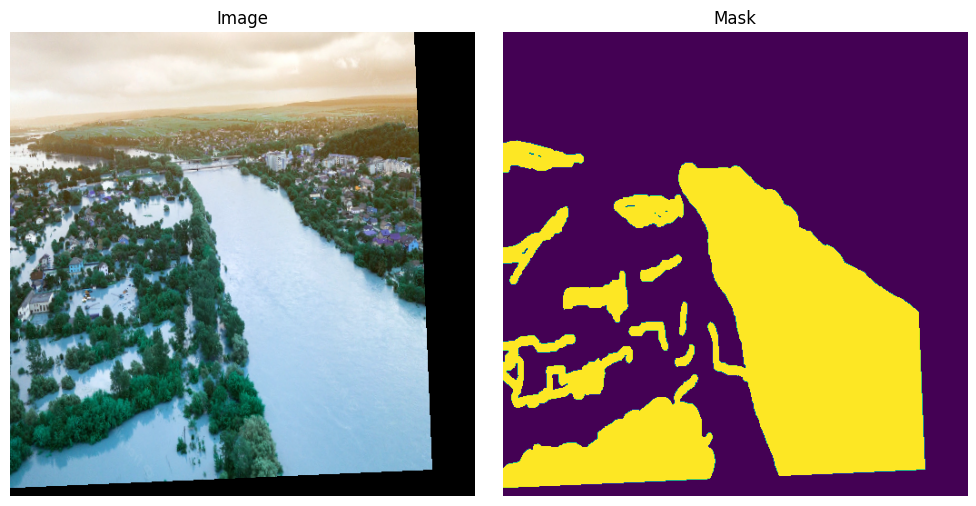

In [8]:
import matplotlib.pyplot as plt

data = CustomDataGenerator(images, masks)
batch_images, batch_masks = data.__getitem__(0)

img = np.random.randint(0,8)
# Visualize the first image and its mask from the batch
image = batch_images[img]
mask = batch_masks[img]

# Plotting the image and its mask
plt.figure(figsize=(10, 5))

# Display Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

# Display Mask
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

**Train and test dataset split**

In [9]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_mask, test_mask = train_test_split(images, masks, test_size=0.2, random_state=42)

In [10]:
len(train_img), len(test_img)

(232, 58)

In [11]:
train_dataset = CustomDataGenerator(train_img, train_mask)
test_dataset = CustomDataGenerator(test_img, test_mask)

In [12]:
len(train_dataset), len(test_dataset)

(29, 8)

**Custom metrics**


1.   Precision
2.   Recall
3.   F1-Score
4.   Dice loss



**Custom loss function**

In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss


# weighted binary crosstropy function
def weighted_binary_crossentropy(y_true, y_pred, weights=[0.5, 0.5]):
    # Calculate weighted binary cross-entropy loss
    class_weighted_loss = BinaryCrossentropy(from_logits=True)
    loss = class_weighted_loss(y_true, y_pred)

    # Calculate class weights for each pixel in the mask
    weights = (1.0 - y_true) * weights[0] + y_true * weights[1]

    # Apply the class weights to the loss for each pixel
    weighted_loss = loss * weights

    # Compute the mean loss over all pixels
    return K.mean(weighted_loss)


**Attention UNET**

In [14]:
# Wrapper function to switch between different loss functions
loss_functions = ['dice_loss', 'binary_crossentropy', 'wbcdl', 'focal_loss']
def get_loss_function(loss_name):
    if loss_name == 'dice_loss':
        return dice_loss
    elif loss_name == 'binary_crossentropy':
        return 'binary_crossentropy'
    elif loss_name == 'focal_loss':
        return BinaryFocalLoss(2.0)
    elif loss_name == 'wbcdl':
      return weighted_binary_crossentropy
    else:
        raise ValueError('Invalid loss function name')


activations = ['relu', 'lru']
def get_activation_function(activation):
  if activation == 'relu':
    return 'relu'
  elif activation == 'lru':
    return LeakyReLU()
  else:
    raise ValueError("Invalid activation function name!")

In [15]:
import tensorflow as tf

from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from focal_loss import BinaryFocalLoss
# from utils.utils import f1_m, precision_m, recall_m, dsc

from sklearn.metrics import *

def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat


def AttnGatingBlock(x, g, inter_shape, activation, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''

    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation(activation)(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, activation, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation(activation,name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation(activation, name=name + '_2_act')(x)
	return x


def UnetGatingSignal(input, is_batchnorm, activation, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation(activation, name = name + '_act')(x)
    return x

K.set_image_data_format('channels_last')  # TF dimension ordering in this code
kinit = 'glorot_normal'

def attn_unet(hp, pretrained_weights = None, input_size = (512,512,3)):

        # some hyperparameters
        filtersFirstLayer = hp.Choice('firstFilterLayer', [32,64,128])

        activation_func_name = hp.Choice('activations', activations)
        activation = get_activation_function(activation_func_name)

        is_batchnorm = hp.Boolean('is_batchnorm')
        lr = hp.Float('lr', min_value=0.0001, max_value=0.01, sampling='log')
        loss_func_name = hp.Choice('loss_func', loss_functions)
        loss_func = get_loss_function(loss_func_name)

        inputs = Input(shape=input_size)
        conv1 = UnetConv2D(inputs, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv1')
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = UnetConv2D(pool1, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv2')
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = UnetConv2D(pool2, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv3')
        #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = UnetConv2D(pool3, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv4')
        #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        center = UnetConv2D(pool4, filtersFirstLayer*4, is_batchnorm=is_batchnorm, activation=activation, name='center')

        g1 = UnetGatingSignal(center, is_batchnorm=is_batchnorm, activation=activation, name='g1')
        attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, activation, '_1')
        up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(center), attn1], name='up1')

        g2 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g2')
        attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, activation, '_2')
        up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up1), attn2], name='up2')

        g3 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g3')
        attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, activation, '_3')
        up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up2), attn3], name='up3')

        up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up3), conv1], name='up4')
        conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)

        model = Model(inputs, conv10)

        model.compile(optimizer = Adam(learning_rate=lr), loss = loss_func, metrics = ['accuracy', f1_m, precision_m, recall_m, dsc])
        # model.summary()

        if(pretrained_weights):
            model.load_weights(pretrained_weights)

        return model

In [16]:
import keras_tuner
model = attn_unet(keras_tuner.HyperParameters())

AttributeError: module 'keras.api.backend' has no attribute 'int_shape'

In [ ]:
# Initialize the tuner (e.g., RandomSearch)
tuner = keras_tuner.RandomSearch(
    attn_unet,
    objective=keras_tuner.Objective("val_f1_m", direction="max"),      # Define the metric to optimize
    max_trials=15,             # Number of hyperparameter combinations to try
    directory='/content/drive/MyDrive/dl/flood/kt',      # Directory to save the results
    project_name='flood_tuner' # Name for the project
)

In [17]:
# Define training data and start the search
tuner.search(train_dataset, epochs=10, validation_data=test_dataset)

NameError: name 'tuner' is not defined

In [ ]:
tuner.search_space_summary()

In [ ]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]

In [ ]:
best_model.summary()

In [ ]:
tuner.results_summary()

**Training model**

In [ ]:
# callback functions
checkpointer = tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/dl/flood/flood_best.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=5, verbose=1, mode='max')

callbacks = [
    earlyStopping,
    checkpointer
    ]

# model training
history = model.fit(train_dataset,epochs=50,
                    verbose = 1,
                    # validation_split=0.15,
                    validation_data=test_dataset,
                    callbacks=callbacks)

# save the model weights at the end of the training process
model.save(f"/content/drive/MyDrive/dl/flood/flood_save.h5")

**Model performance**

In [ ]:
fig,((ax11, ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(10,10))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

**Load best model**

In [ ]:
from keras.models import load_model

# Define the custom loss function before loading the model
custom_objects = {"f1_m": f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'dsc': dsc}

model = load_model('/content/drive/MyDrive/dl/flood/flood_best.h5', custom_objects=custom_objects)

# pred

In [ ]:
# accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
loss, accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
print(loss, accuracy, f1_score, precision, recall, dsc)

**Prediction on custom images**

In [ ]:
import glob
imgs = glob.glob('/content/*.jpg')

img_test = np.zeros((3, 512, 512, 3))
for index, i in enumerate(imgs):
  img = cv2.imread(i)
  img = cv2.resize(img, (512, 512))
  img = img / 255.0
  # print(img.shape)
  img_test[index] = img

In [ ]:
pred = model.predict(img_test)
pred = np.where(pred > 0.5, 1, 0)
pred.shape

In [ ]:
fig,(axes)= plt.subplots(3, 2, figsize=(12,12))

for i in range(3):
    # Load and display the original image
    axes[i, 0].imshow(img_test[i])
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    # Load and display the corresponding prediction
    axes[i, 1].imshow(pred[i])
    axes[i, 1].set_title(f'Prediction {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()